In [1]:
%matplotlib inline

In [2]:
import tensorflow as tf
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.preprocessing import *
from tensorflow.keras.applications.resnet50 import preprocess_input, decode_predictions
from tensorflow.keras.layers import *
from tensorflow.keras.models import *
from tensorflow.keras.preprocessing.image import *
import numpy as np
import pandas as pd
import os
import cv2
from PIL import Image
from google.colab.patches import cv2_imshow # for image display
from matplotlib import pyplot as plt
import sklearn as sk
import seaborn as sns

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#Prepare data

In [4]:
CSV_PATH = "/content/drive/MyDrive/Tesis/Datasets/Products/annotations.csv"
IMAGES_PATH = "/content/drive/MyDrive/Tesis/Datasets/Products/Images/"

In [5]:

def pre_process_data(path,images_path =""):
  colnames=['filename','xmin', 'ymin', 'xmax', 'ymax',\
            'class','width','height']
  
  annotate_data=pd.read_csv(path,header=None)
  annotate_data.columns = colnames
  annotate_data['filename'] = images_path+annotate_data['filename'].astype(str)
  annotate_data = annotate_data[['filename', 'class','width', 'height', 'xmin','ymin','xmax','ymax']]
  annotate_data = annotate_data[annotate_data['class'] != 1]
  return annotate_data

images_df = pre_process_data(CSV_PATH,IMAGES_PATH)

In [6]:
images_df.head()

,filename,class,width,height,xmin,ymin,xmax,ymax
150,/content/drive/MyDrive/Tesis/Datasets/Products...,8,3024,4032,18,6,275,520
151,/content/drive/MyDrive/Tesis/Datasets/Products...,7,3024,4032,320,12,520,526
152,/content/drive/MyDrive/Tesis/Datasets/Products...,6,3024,4032,1282,9,1506,502
153,/content/drive/MyDrive/Tesis/Datasets/Products...,6,3024,4032,1034,9,1261,505
154,/content/drive/MyDrive/Tesis/Datasets/Products...,7,3024,4032,1153,711,1458,1936


In [7]:
images_df.dtypes

filename    object
class        int64
width        int64
height       int64
xmin         int64
ymin         int64
xmax         int64
ymax         int64
dtype: object

In [8]:
num_classes = len(list(images_df['class'].unique()))
num_classes

12

In [9]:
classes_ids = list(images_df['class'].unique())
classes_ids.sort()
classes_ids

[2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13]

In [ ]:
ids = {'object':0,'fluo_cardent':1,'zucaritas':2,'chocokrispis':3,'fruit_loops':4,'colombiana':5,'manzana':6,'pepsi':7,'corn_flakes':8,'papas_limon':9,'colgate':10,'papas_pollo':11,'papas_natural':12}
for k in ids.keys():
    ids[k] += 1
category_id_to_name = {ids[k]:k for k in ids.keys()}

classes_names = [category_id_to_name[i] for i in classes_ids]
classes_names

['fluo_cardent',
 'zucaritas',
 'chocokrispis',
 'fruit_loops',
 'colombiana',
 'manzana',
 'pepsi',
 'corn_flakes',
 'papas_limon',
 'colgate',
 'papas_pollo',
 'papas_natural']

In [ ]:
class_count = {classes_names[i]:0 for i in range(len(classes_names))}
total_crops=0
for index,row in images_df.iterrows():
  class_count[category_id_to_name[row['class']]] += 1
  total_crops += 1
class_count


{'chocokrispis': 173,
 'colgate': 104,
 'colombiana': 90,
 'corn_flakes': 49,
 'fluo_cardent': 108,
 'fruit_loops': 157,
 'manzana': 70,
 'papas_limon': 112,
 'papas_natural': 90,
 'papas_pollo': 93,
 'pepsi': 46,
 'zucaritas': 141}

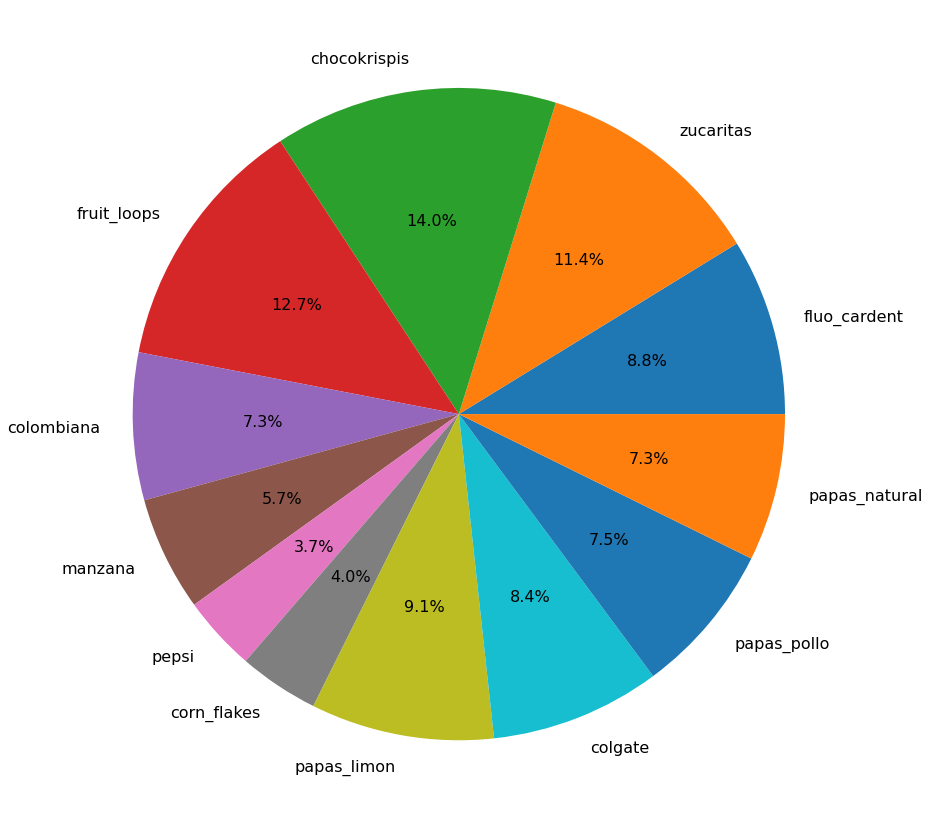

In [ ]:
#print(sum([class_count[k]/total_crops for k in class_count.keys()]))
plt.figure(figsize=(15, 15))
plt.pie([class_count[k]/total_crops for k in class_count.keys()],labels=class_count.keys(),autopct='%1.1f%%',textprops={'fontsize': 16})
plt.show()

## Using SMOTE

In [ ]:
#https://medium.com/swlh/how-to-use-smote-for-dealing-with-imbalanced-image-dataset-for-solving-classification-problems-3aba7d2b9cad
#https://stackoverflow.com/questions/53666759/use-smote-to-oversample-image-data
#https://machinelearningmastery.com/random-oversampling-and-undersampling-for-imbalanced-classification/
"""
SMOTE funciona seleccionando ejemplos cercanos en el espacio de características, 
dibujando una línea entre los ejemplos en el espacio de características y d
ibujando una nueva muestra en un punto a lo largo de esa línea.

Específicamente, primero se elige un ejemplo aleatorio de la clase minoritaria. 
Entonces se encuentran k de los vecinos más cercanos para ese ejemplo (típicamente k = 5). 
Se elige un vecino seleccionado al azar y se crea un ejemplo sintético en un punto seleccionado al azar entre los 
dos ejemplos en el espacio de características. 
"""
#from sklearn.preprocessing import LabelEncoder
#le = LabelEncoder()
#images_df['filename'] = le.fit_transform(images_df['filename'])
from imblearn.over_sampling import RandomOverSampler
oversample = RandomOverSampler(random_state=3)

X_over, y_over = oversample.fit_resample(images_df.drop(['class'],axis=1), images_df['class'])


In [ ]:
images_df = (X_over.merge(y_over.to_frame(),left_index=True,right_index=True))
images_df.head()

,filename,width,height,xmin,ymin,xmax,ymax,class
0,/content/drive/MyDrive/Tesis/Datasets/Products...,3024,4032,18,6,275,520,8
1,/content/drive/MyDrive/Tesis/Datasets/Products...,3024,4032,320,12,520,526,7
2,/content/drive/MyDrive/Tesis/Datasets/Products...,3024,4032,1282,9,1506,502,6
3,/content/drive/MyDrive/Tesis/Datasets/Products...,3024,4032,1034,9,1261,505,6
4,/content/drive/MyDrive/Tesis/Datasets/Products...,3024,4032,1153,711,1458,1936,7


In [ ]:
from imblearn.over_sampling import SMOTE
sm = SMOTE(random_state=42)
X_smote, y_smote = sm.fit_resample(images_df.drop(['class'],axis=1), images_df['class'])
#X_train, X_test, y_train, y_test = train_test_split(data.drop(['F11'],axis=1), data['F11'], test_size=0.4)

In [ ]:
num_classes = len(list(images_df['class'].unique()))
num_classes

12

In [ ]:
class_count = {classes_names[i]:0 for i in range(len(classes_names))}
total_crops=0
for index,row in images_df.iterrows():
  class_count[category_id_to_name[row['class']]] += 1
  total_crops += 1
class_count

{'chocokrispis': 173,
 'colgate': 173,
 'colombiana': 173,
 'corn_flakes': 173,
 'fluo_cardent': 173,
 'fruit_loops': 173,
 'manzana': 173,
 'papas_limon': 173,
 'papas_natural': 173,
 'papas_pollo': 173,
 'pepsi': 173,
 'zucaritas': 173}

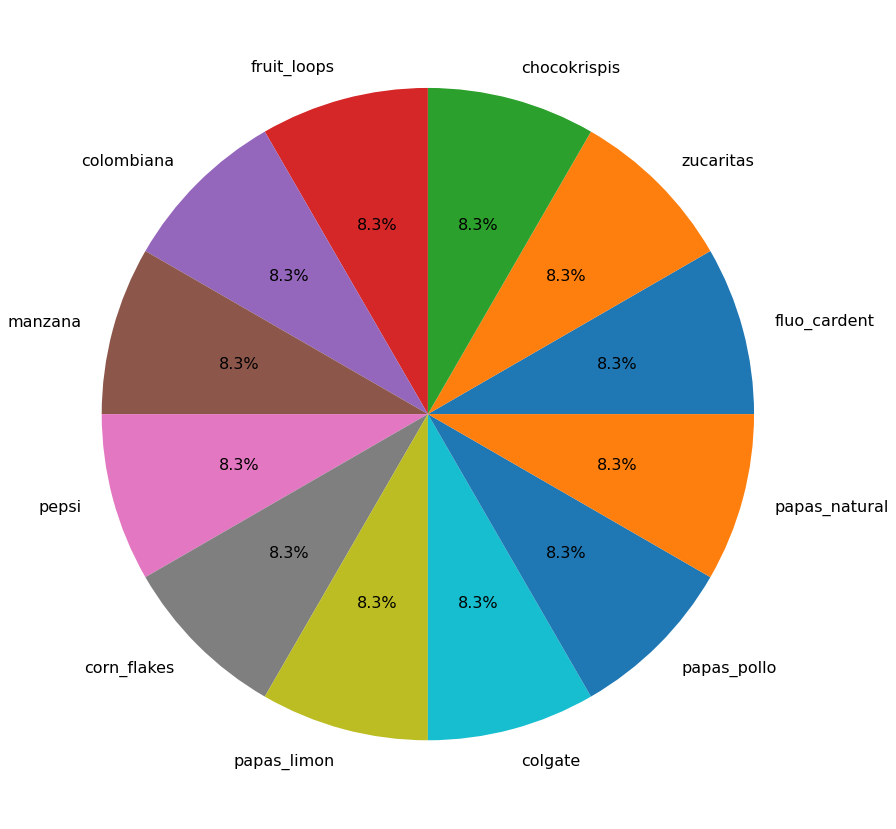

In [ ]:
#print(sum([class_count[k]/total_crops for k in class_count.keys()]))
plt.figure(figsize=(15, 15))
plt.pie([class_count[k]/total_crops for k in class_count.keys()],labels=class_count.keys(),autopct='%1.1f%%',textprops={'fontsize': 16})
plt.show()

## Make crops for images

In [ ]:
#Create directory for each class
cwd = os.getcwd()
dir = os.path.join(cwd,"images")

if not os.path.exists(dir): os.mkdir(dir)
for name in classes_ids:
  dir = os.path.join(cwd,"images",str(name))
  if not os.path.exists(dir):
    os.mkdir(dir)


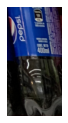

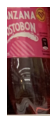

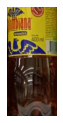

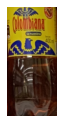

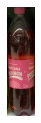

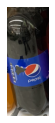

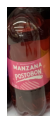

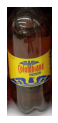

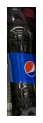

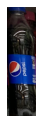

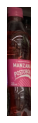

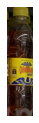

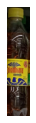

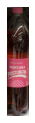

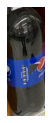

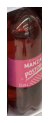

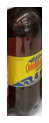

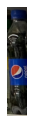

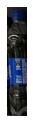

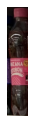

In [ ]:
crops_names = {name:0 for name in category_id_to_name}
dims = []
def make_partitions():
  N = 20
  for index,row in images_df.iterrows():
    xmin,ymin,xmax,ymax = row['xmin'],row['ymin'],row['xmax'],row['ymax']
    w,h = xmax-xmin,ymax-ymin
    img = cv2.imread(row['filename'])
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = img[ymin:ymin+h,xmin:xmin+w]
    #dir = os.path.join(cwd,"images",category_id_to_name[row['class']],category_id_to_name[row['class']]+str(crops_names[row['class']])+".jpg")
    dir = os.path.join(cwd,"images",str(row['class']),category_id_to_name[row['class']]+str(crops_names[row['class']])+".jpg")
    
    crops_names[row['class']] += 1
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    cv2.imwrite(dir,img)
    dims.append(img.shape)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    if N > 0:
      plt.figure(figsize=(2, 2))
      plt.axis('off')
      plt.imshow(img)
    
    N -= 1
make_partitions()

In [ ]:
crops_names

{1: 0,
 2: 0,
 3: 0,
 4: 0,
 5: 0,
 6: 0,
 7: 0,
 8: 0,
 9: 0,
 10: 0,
 11: 0,
 12: 0,
 13: 0}

In [ ]:
!zip -r '/content/images.zip' '/content/images'

Se truncaron las últimas líneas 5000 del resultado de transmisión.
  adding: content/images/1/object3348.jpg (deflated 0%)
  adding: content/images/1/object1122.jpg (deflated 1%)
  adding: content/images/1/object5469.jpg (deflated 0%)
  adding: content/images/1/object877.jpg (deflated 0%)
  adding: content/images/1/object4757.jpg (deflated 1%)
  adding: content/images/1/object2504.jpg (deflated 1%)
  adding: content/images/1/object3557.jpg (deflated 1%)
  adding: content/images/1/object4584.jpg (deflated 4%)
  adding: content/images/1/object1772.jpg (deflated 1%)
  adding: content/images/1/object174.jpg (deflated 0%)
  adding: content/images/1/object2069.jpg (deflated 0%)
  adding: content/images/1/object2952.jpg (deflated 1%)
  adding: content/images/1/object2691.jpg (deflated 1%)
  adding: content/images/1/object3224.jpg (deflated 1%)
  adding: content/images/1/object5266.jpg (deflated 2%)
  adding: content/images/1/object4211.jpg (deflated 1%)
  adding: content/images/1/object3118.j

In [12]:
#data_dir = os.path.join(cwd,"images")
train_dir = "/content/drive/MyDrive/Tesis/Datasets/Productos_partition_processed/train"
val_dir = "/content/drive/MyDrive/Tesis/Datasets/Productos_partition_processed/val"
test_dir = "/content/drive/MyDrive/Tesis/Datasets/Productos_partition_processed/test"


#Resnet 

In [ ]:
img_height,img_width = 224,224
batch_size = 32

In [ ]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  train_dir,
  label_mode = 'categorical',
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)#porque batch size?


Found 735 files belonging to 12 classes.


In [ ]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  val_dir,
  label_mode = 'categorical',
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)#porque batch size?

Found 242 files belonging to 12 classes.


In [ ]:
test_ds = tf.keras.preprocessing.image_dataset_from_directory(
  test_dir,
  label_mode = 'categorical',
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)#porque batch size?

Found 256 files belonging to 12 classes.


In [ ]:
AUTOTUNE = tf.data.AUTOTUNE

#train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
#val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
for elem in train_ds.as_numpy_iterator():
  print(elem)
  break

(array([[[[1.83785721e+02, 1.62044647e+02, 9.16339264e+01],
         [1.84748734e+02, 1.63007660e+02, 9.23112259e+01],
         [1.87637756e+02, 1.65896683e+02, 9.43431091e+01],
         ...,
         [1.52852036e+02, 1.43852036e+02, 1.26852043e+02],
         [1.52963013e+02, 1.43963013e+02, 1.26963013e+02],
         [1.53000000e+02, 1.44000000e+02, 1.27000000e+02]],

        [[2.41446426e+02, 2.14669647e+02, 1.04544640e+02],
         [2.40985962e+02, 2.14605865e+02, 1.04116066e+02],
         [2.39604599e+02, 2.14414536e+02, 1.02830353e+02],
         ...,
         [1.53000000e+02, 1.44000000e+02, 1.27000000e+02],
         [1.53000000e+02, 1.44000000e+02, 1.27000000e+02],
         [1.53000000e+02, 1.44000000e+02, 1.27000000e+02]],

        [[2.40883926e+02, 2.17294647e+02, 8.95892868e+01],
         [2.40698975e+02, 2.17109695e+02, 8.94043350e+01],
         [2.40144135e+02, 2.16554855e+02, 8.88494873e+01],
         ...,
         [1.56116074e+02, 1.45000000e+02, 1.28705353e+02],
         

In [ ]:
train_ds.class_names

['10', '11', '12', '13', '2', '3', '4', '5', '6', '7', '8', '9']

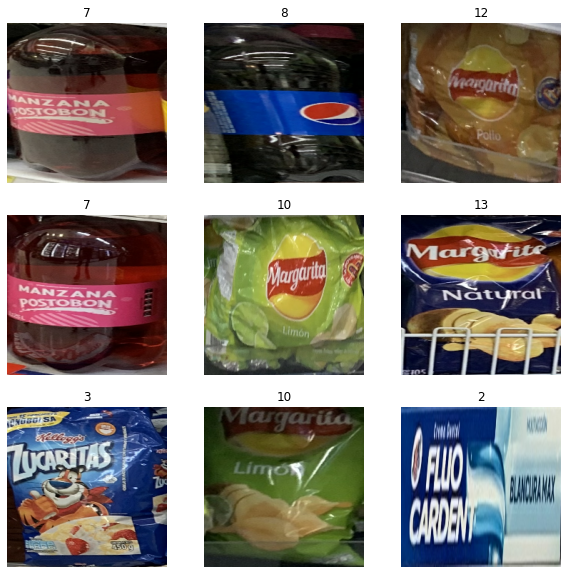

In [ ]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(train_ds.class_names[labels[i]])
    plt.axis("off")


In [ ]:
#https://keras.io/guides/transfer_learning/
resnet = ResNet50(include_top=False,weights='imagenet',input_shape=(img_height,img_width,3))

resnet.trainable = False
inputs = tf.keras.Input(shape=(img_height,img_width,3))
x = resnet(inputs,training=False)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
outputs = tf.keras.layers.Dense(num_classes,activation='softmax')(x)
model = tf.keras.Model(inputs,outputs)

# x = resnet.output
# x = GlobalAveragePooling2D()(x)
# x = Dense(1024,activation='relu')(x)
# preds = Dense(num_classes,activation='softmax')(x)
# model = Model(inputs=resnet.input,outputs=preds)

#for layer in resnet.layers:
#  layer.trainable = False
#sparse_categorical_crossentropy
#tf.keras.losses.CosineSimilarity(axis=-1)
model.compile(optimizer='adam',loss=tf.keras.losses.CosineSimilarity(axis=-1),metrics=['accuracy'])
model.summary()


94781440/94765736 [==============================] - 1s 0us/step
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 12)                24588     
                                                                 
Total params: 23,612,300
Trainable params: 24,588
Non-trainable params: 23,587,712
_________________________________________________________________


In [ ]:
%%time
epochs = 30
history = model.fit(train_ds,epochs=epochs,validation_data=val_ds)

Epoch 1/30
23/23 [==============================] - 238s 9s/step - loss: -0.6606 - accuracy: 0.6218 - val_loss: -0.9068 - val_accuracy: 0.9132
Epoch 2/30
23/23 [==============================] - 154s 7s/step - loss: -0.9480 - accuracy: 0.9551 - val_loss: -0.9590 - val_accuracy: 0.9628
Epoch 3/30
23/23 [==============================] - 154s 7s/step - loss: -0.9848 - accuracy: 0.9905 - val_loss: -0.9694 - val_accuracy: 0.9793
Epoch 4/30
23/23 [==============================] - 154s 7s/step - loss: -0.9914 - accuracy: 0.9959 - val_loss: -0.9744 - val_accuracy: 0.9793
Epoch 5/30
23/23 [==============================] - 154s 7s/step - loss: -0.9951 - accuracy: 0.9986 - val_loss: -0.9769 - val_accuracy: 0.9793
Epoch 6/30
23/23 [==============================] - 155s 7s/step - loss: -0.9966 - accuracy: 1.0000 - val_loss: -0.9798 - val_accuracy: 0.9835
Epoch 7/30
23/23 [==============================] - 156s 7s/step - loss: -0.9977 - accuracy: 1.0000 - val_loss: -0.9803 - val_accuracy: 0.9835

In [ ]:
model.save('content/resnet_retail_cosine.h5')

/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


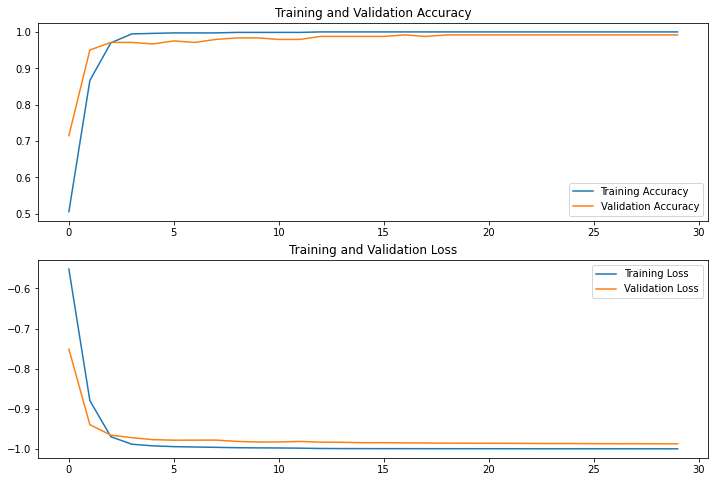

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(len(acc))
plt.figure(figsize=(12, 8))
plt.subplot(2, 1, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')
plt.subplot(2, 1, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [ ]:
from tensorflow.keras.models import load_model
model = load_model('/content/drive/MyDrive/Tesis/imageClassificationWeights/originalData/Resnet/resnet_retail.h5')

In [ ]:
test_loss,test_acc = model.evaluate(test_ds,verbose=2)
print("Test accuracy:",test_acc)

8/8 - 63s - loss: 0.0520 - accuracy: 0.9844 - 63s/epoch - 8s/step
Test accuracy: 0.984375


In [ ]:
#model = tf.keras.models.load_model("/content/drive/MyDrive/Tesis/imageClassificationWeights/Resnet/resnet_retail.h5")
# preds = list(model.predict(test_ds))
# preds = [list(preds[i]).index(max(preds[i])) for i in range(len(preds))]
# preds

cwd = os.getcwd()
dir = os.path.join(cwd,"images")
preds = []
labels = []
for sub_dir in os.listdir(test_dir):
  for img_name in os.listdir(os.path.join(test_dir,sub_dir)):
    img_dir = os.path.join(test_dir,sub_dir,img_name)
    #print(img_dir)
    img = tf.keras.utils.load_img(img_dir, target_size=(img_height, img_width))
    img = tf.keras.utils.img_to_array(img)
    img = tf.expand_dims(img, 0)
    #img = preprocess_input(img)
    pred = model.predict(img)
    labels.append(int(sub_dir)-2)
    pred = list(pred[0])
    #print(pred)
    #break
    preds.append(int(test_ds.class_names[np.argmax(pred)])-2)
    
    assert 0 <= preds[-1] <= num_classes-1
    

    
    #print(pred)
    #break
  #break

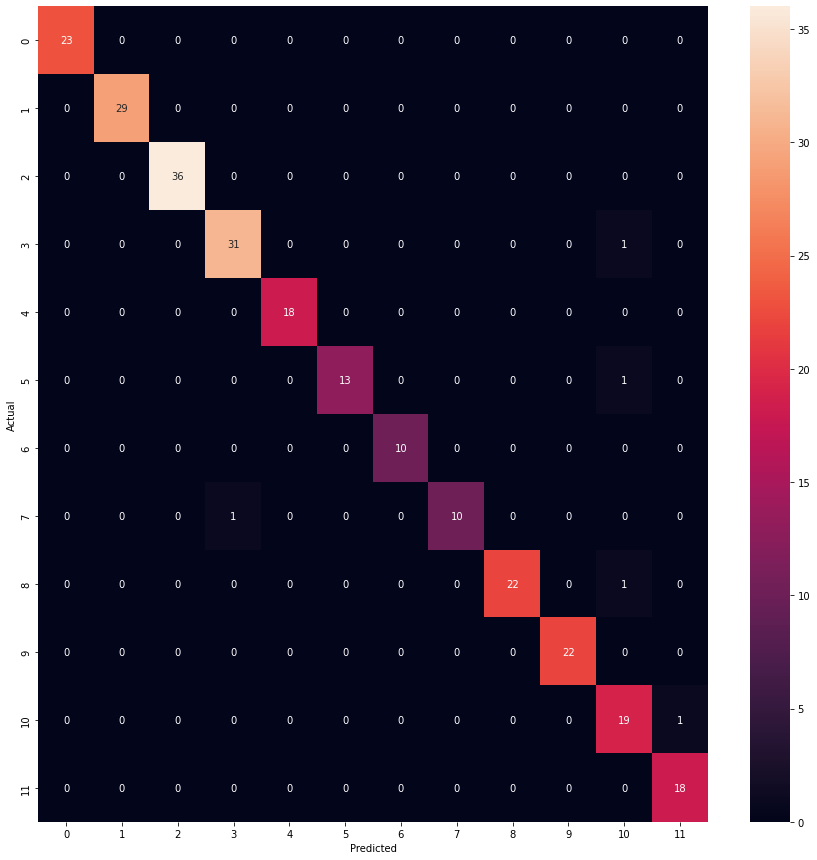

In [ ]:
from sklearn.metrics import confusion_matrix

assert len(labels) == len(preds)
conf_matrix = confusion_matrix(labels,preds)#tf.math.confusion_matrix(labels=labels, predictions=preds, num_classes=num_classes)
#conf_matrix
plt.figure(figsize=(15, 15))
conf_matrix = pd.crosstab(np.array(labels), np.array(preds), rownames=['Actual'], colnames=['Predicted'])
sns.heatmap(conf_matrix, annot=True)

plt.show()

In [ ]:
#https://towardsdatascience.com/confusion-matrix-for-your-multi-class-machine-learning-model-ff9aa3bf7826
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
print('\nAccuracy: {:.5f}\n'.format(accuracy_score(labels, preds)))

print('Micro Precision: {:.5f}'.format(precision_score(labels, preds, average='micro')))
print('Micro Recall: {:.5f}'.format(recall_score(labels, preds, average='micro')))
print('Micro F1-score: {:.5f}\n'.format(f1_score(labels, preds, average='micro')))

print('Macro Precision: {:.5f}'.format(precision_score(labels, preds, average='macro')))
print('Macro Recall: {:.5f}'.format(recall_score(labels, preds, average='macro')))
print('Macro F1-score: {:.5f}\n'.format(f1_score(labels, preds, average='macro')))

print('Weighted Precision: {:.5f}'.format(precision_score(labels, preds, average='weighted')))
print('Weighted Recall: {:.5f}'.format(recall_score(labels, preds, average='weighted')))
print('Weighted F1-score: {:.5f}'.format(f1_score(labels, preds, average='weighted')))


Accuracy: 0.98047

Micro Precision: 0.98047
Micro Recall: 0.98047
Micro F1-score: 0.98047

Macro Precision: 0.98165
Macro Recall: 0.97608
Macro F1-score: 0.97830

Weighted Precision: 0.98174
Weighted Recall: 0.98047
Weighted F1-score: 0.98068


In [ ]:
from sklearn.metrics import classification_report
report = classification_report(labels, preds, target_names=['Class {0}'.format(i+1) for i in range(num_classes)])
print(report)

              precision    recall  f1-score   support

     Class 1       1.00      1.00      1.00        23
     Class 2       1.00      1.00      1.00        29
     Class 3       1.00      1.00      1.00        36
     Class 4       0.97      0.97      0.97        32
     Class 5       1.00      1.00      1.00        18
     Class 6       1.00      0.93      0.96        14
     Class 7       1.00      1.00      1.00        10
     Class 8       1.00      0.91      0.95        11
     Class 9       1.00      0.96      0.98        23
    Class 10       1.00      1.00      1.00        22
    Class 11       0.86      0.95      0.90        20
    Class 12       0.95      1.00      0.97        18

    accuracy                           0.98       256
   macro avg       0.98      0.98      0.98       256
weighted avg       0.98      0.98      0.98       256



# VGG 19

In [ ]:
img_height,img_width = 224,224
batch_size = 32

In [ ]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  train_dir,
  label_mode = 'categorical',
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)#porque batch size?


Found 735 files belonging to 12 classes.


In [ ]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  val_dir,
  label_mode = 'categorical',
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)#porque batch size?

Found 242 files belonging to 12 classes.


In [ ]:
test_ds = tf.keras.preprocessing.image_dataset_from_directory(
  test_dir,
  label_mode = 'categorical',
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)#porque batch size?

Found 256 files belonging to 12 classes.


In [ ]:
train_ds.class_names

['10', '11', '12', '13', '2', '3', '4', '5', '6', '7', '8', '9']

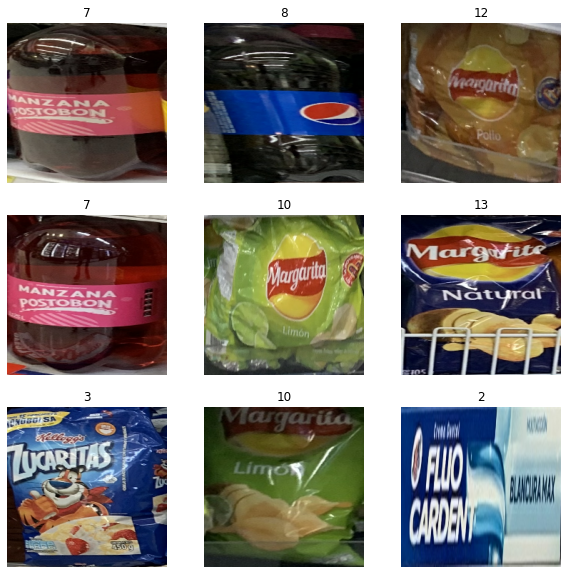

In [ ]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(train_ds.class_names[labels[i]])
    plt.axis("off")


In [ ]:
from tensorflow.keras.applications.vgg19 import VGG19
VGG19 = VGG19(include_top=False,weights='imagenet',input_shape=(img_height,img_width,3))

VGG19.trainable = False
inputs = tf.keras.Input(shape=(img_height,img_width,3))
x = VGG19(inputs,training=False)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
outputs = tf.keras.layers.Dense(num_classes,activation='softmax')(x)
model = tf.keras.Model(inputs,outputs)

# x = resnet.output
# x = GlobalAveragePooling2D()(x)
# x = Dense(1024,activation='relu')(x)
# preds = Dense(num_classes,activation='softmax')(x)
# model = Model(inputs=resnet.input,outputs=preds)

#for layer in resnet.layers:
#  layer.trainable = False
#tf.keras.losses.CosineSimilarity(axis=-1)
#'sparse_categorical_crossentropy'
model.compile(optimizer='adam',loss=tf.keras.losses.CosineSimilarity(axis=-1),metrics=['accuracy'])
model.summary()


80150528/80134624 [==============================] - 1s 0us/step
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 vgg19 (Functional)          (None, 7, 7, 512)         20024384  
                                                                 
 global_average_pooling2d_1   (None, 512)              0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_1 (Dense)             (None, 12)                6156      
                                                                 
Total params: 20,030,540
Trainable params: 6,156
Non-trainable params: 20,024,384
_________________________________________________________________


In [ ]:
%%time
epochs = 30
history = model.fit(train_ds,epochs=epochs,validation_data=val_ds)

Epoch 1/30
23/23 [==============================] - 627s 27s/step - loss: -0.2002 - accuracy: 0.1782 - val_loss: -0.2389 - val_accuracy: 0.2273
Epoch 2/30
23/23 [==============================] - 625s 27s/step - loss: -0.3633 - accuracy: 0.3429 - val_loss: -0.4357 - val_accuracy: 0.4091
Epoch 3/30
23/23 [==============================] - 626s 28s/step - loss: -0.5330 - accuracy: 0.5156 - val_loss: -0.5482 - val_accuracy: 0.5207
Epoch 4/30
23/23 [==============================] - 626s 27s/step - loss: -0.6664 - accuracy: 0.6408 - val_loss: -0.6665 - val_accuracy: 0.6612
Epoch 5/30
23/23 [==============================] - 626s 27s/step - loss: -0.7445 - accuracy: 0.7306 - val_loss: -0.6958 - val_accuracy: 0.6777
Epoch 6/30
23/23 [==============================] - 628s 28s/step - loss: -0.8092 - accuracy: 0.8014 - val_loss: -0.7732 - val_accuracy: 0.7521
Epoch 7/30
23/23 [==============================] - 631s 28s/step - loss: -0.8309 - accuracy: 0.8259 - val_loss: -0.7897 - val_accuracy:

In [ ]:
model.save('content/VGG19_retail_cosine.h5')

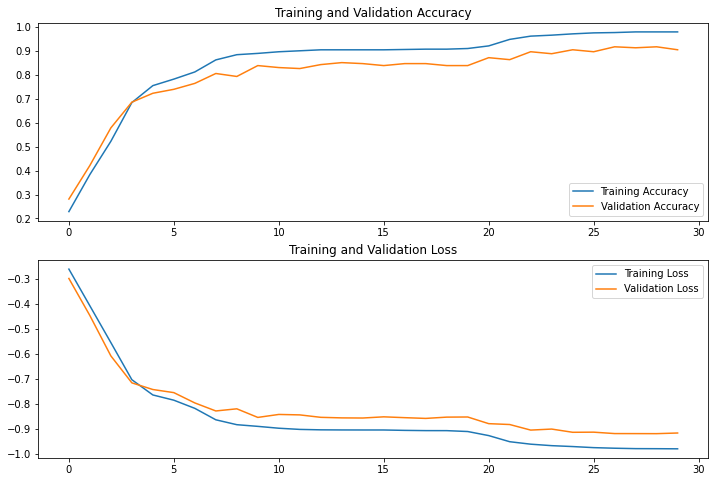

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(len(acc))
plt.figure(figsize=(12, 8))
plt.subplot(2, 1, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')
plt.subplot(2, 1, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [ ]:
from tensorflow.keras.models import load_model
model = load_model('/content/drive/MyDrive/Tesis/imageClassificationWeights/originalData/VGG19/VGG19_retail.h5')

In [ ]:
test_loss,test_acc = model.evaluate(test_ds,verbose=2)
print("Test accuracy:",test_acc)

8/8 - 145s - loss: 0.2320 - accuracy: 0.9375 - 145s/epoch - 18s/step
Test accuracy: 0.9375


In [ ]:
#model = tf.keras.models.load_model("/content/drive/MyDrive/Tesis/imageClassificationWeights/Resnet/resnet_retail.h5")
# preds = list(model.predict(test_ds))
# preds = [list(preds[i]).index(max(preds[i])) for i in range(len(preds))]
# preds

cwd = os.getcwd()
dir = os.path.join(cwd,"images")
preds = []
labels = []
for sub_dir in os.listdir(test_dir):
  for img_name in os.listdir(os.path.join(test_dir,sub_dir)):
    img_dir = os.path.join(test_dir,sub_dir,img_name)
    #print(img_dir)
    img = tf.keras.utils.load_img(img_dir, target_size=(img_height, img_width))
    img = tf.keras.utils.img_to_array(img)
    img = tf.expand_dims(img, 0)
    #img = preprocess_input(img)
    pred = model.predict(img)
    labels.append(int(sub_dir)-2)
    pred = list(pred[0])
    preds.append(int(test_ds.class_names[np.argmax(pred)])-2)
    
    assert 0 <= preds[-1] <= num_classes-1
    

    
    #print(pred)
    #break
  #break

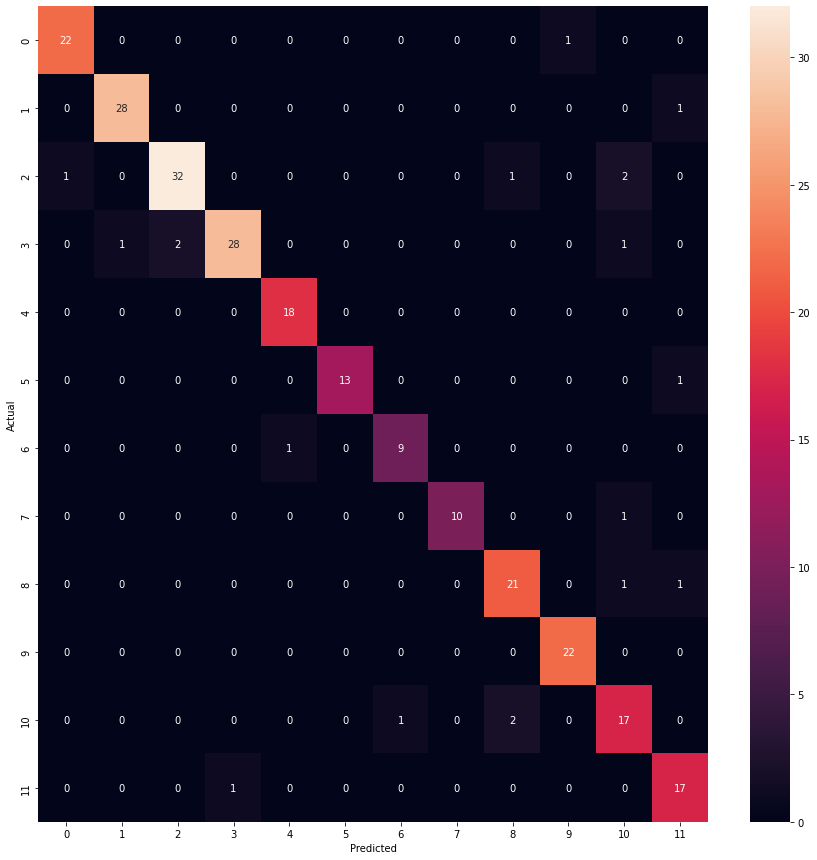

In [ ]:
from sklearn.metrics import confusion_matrix

assert len(labels) == len(preds)
conf_matrix = confusion_matrix(labels,preds)#tf.math.confusion_matrix(labels=labels, predictions=preds, num_classes=num_classes)
#conf_matrix
plt.figure(figsize=(15, 15))
conf_matrix = pd.crosstab(np.array(labels), np.array(preds), rownames=['Actual'], colnames=['Predicted'])
sns.heatmap(conf_matrix, annot=True)

plt.show()

In [ ]:
#https://towardsdatascience.com/confusion-matrix-for-your-multi-class-machine-learning-model-ff9aa3bf7826
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
print('\nAccuracy: {:.5f}\n'.format(accuracy_score(labels, preds)))

print('Micro Precision: {:.5f}'.format(precision_score(labels, preds, average='micro')))
print('Micro Recall: {:.5f}'.format(recall_score(labels, preds, average='micro')))
print('Micro F1-score: {:.5f}\n'.format(f1_score(labels, preds, average='micro')))

print('Macro Precision: {:.5f}'.format(precision_score(labels, preds, average='macro')))
print('Macro Recall: {:.5f}'.format(recall_score(labels, preds, average='macro')))
print('Macro F1-score: {:.5f}\n'.format(f1_score(labels, preds, average='macro')))

print('Weighted Precision: {:.5f}'.format(precision_score(labels, preds, average='weighted')))
print('Weighted Recall: {:.5f}'.format(recall_score(labels, preds, average='weighted')))
print('Weighted F1-score: {:.5f}'.format(f1_score(labels, preds, average='weighted')))


Accuracy: 0.92578

Micro Precision: 0.92578
Micro Recall: 0.92578
Micro F1-score: 0.92578

Macro Precision: 0.92753
Macro Recall: 0.92759
Macro F1-score: 0.92653

Weighted Precision: 0.92873
Weighted Recall: 0.92578
Weighted F1-score: 0.92626


In [ ]:
from sklearn.metrics import classification_report
report = classification_report(labels, preds, target_names=['Class {0}'.format(i+1) for i in range(num_classes)])
print(report)

              precision    recall  f1-score   support

     Class 1       0.96      0.96      0.96        23
     Class 2       0.97      0.97      0.97        29
     Class 3       0.94      0.89      0.91        36
     Class 4       0.97      0.88      0.92        32
     Class 5       0.95      1.00      0.97        18
     Class 6       1.00      0.93      0.96        14
     Class 7       0.90      0.90      0.90        10
     Class 8       1.00      0.91      0.95        11
     Class 9       0.88      0.91      0.89        23
    Class 10       0.96      1.00      0.98        22
    Class 11       0.77      0.85      0.81        20
    Class 12       0.85      0.94      0.89        18

    accuracy                           0.93       256
   macro avg       0.93      0.93      0.93       256
weighted avg       0.93      0.93      0.93       256



# InceptionV3

In [ ]:
img_height,img_width = 224,224
batch_size = 32

In [ ]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  train_dir,
  label_mode = 'int',
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)#porque batch size?


Found 735 files belonging to 12 classes.


In [ ]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  val_dir,
  label_mode = 'int',
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)#porque batch size?

Found 242 files belonging to 12 classes.


In [ ]:
test_ds = tf.keras.preprocessing.image_dataset_from_directory(
  test_dir,
  label_mode = 'int',
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)#porque batch size?

Found 256 files belonging to 12 classes.


In [ ]:
train_ds.class_names

['10', '11', '12', '13', '2', '3', '4', '5', '6', '7', '8', '9']

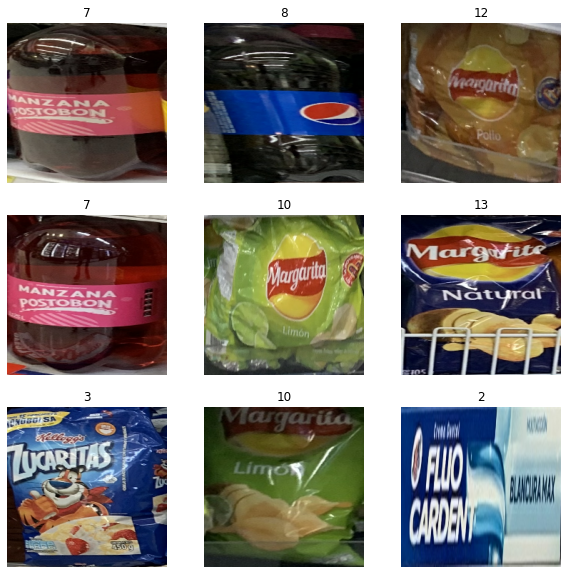

In [ ]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(train_ds.class_names[labels[i]])
    plt.axis("off")


In [ ]:
from tensorflow.keras.applications.inception_v3 import InceptionV3
inception = InceptionV3(include_top=False,weights='imagenet',input_shape=(img_height,img_width,3))

inception.trainable = False
inputs = tf.keras.Input(shape=(img_height,img_width,3))
x = inception(inputs,training=False)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
outputs = tf.keras.layers.Dense(num_classes,activation='softmax')(x)
model = tf.keras.Model(inputs,outputs)

# x = resnet.output
# x = GlobalAveragePooling2D()(x)
# x = Dense(1024,activation='relu')(x)
# preds = Dense(num_classes,activation='softmax')(x)
# model = Model(inputs=resnet.input,outputs=preds)

#for layer in resnet.layers:
#  layer.trainable = False

model.compile(optimizer='adam',loss='sparse_categorical_crossentropy',metrics=['accuracy'])
model.summary()


87924736/87910968 [==============================] - 1s 0us/step
Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 inception_v3 (Functional)   (None, 5, 5, 2048)        21802784  
                                                                 
 global_average_pooling2d_2   (None, 2048)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_2 (Dense)             (None, 12)                24588     
                                                                 
Total params: 21,827,372
Trainable params: 24,588
Non-trainable params: 21,802,784
_________________________________________________________________


In [ ]:
%%time
epochs = 30
history = model.fit(train_ds,epochs=epochs,validation_data=val_ds)

Epoch 1/30
23/23 [==============================] - 116s 5s/step - loss: 13.9577 - accuracy: 0.2204 - val_loss: 6.1439 - val_accuracy: 0.3719
Epoch 2/30
23/23 [==============================] - 106s 5s/step - loss: 4.8329 - accuracy: 0.5224 - val_loss: 4.3467 - val_accuracy: 0.4876
Epoch 3/30
23/23 [==============================] - 106s 5s/step - loss: 2.9166 - accuracy: 0.6245 - val_loss: 2.7718 - val_accuracy: 0.6157
Epoch 4/30
23/23 [==============================] - 108s 5s/step - loss: 1.9372 - accuracy: 0.6980 - val_loss: 2.6932 - val_accuracy: 0.6405
Epoch 5/30
23/23 [==============================] - 109s 5s/step - loss: 2.0310 - accuracy: 0.7116 - val_loss: 2.0413 - val_accuracy: 0.6529
Epoch 6/30
23/23 [==============================] - 107s 5s/step - loss: 1.1209 - accuracy: 0.7918 - val_loss: 2.2078 - val_accuracy: 0.6612
Epoch 7/30
23/23 [==============================] - 108s 5s/step - loss: 1.0532 - accuracy: 0.7946 - val_loss: 1.7359 - val_accuracy: 0.7355
Epoch 8/30
2

In [ ]:
model.save('content/inception_retail_cosine.h5')

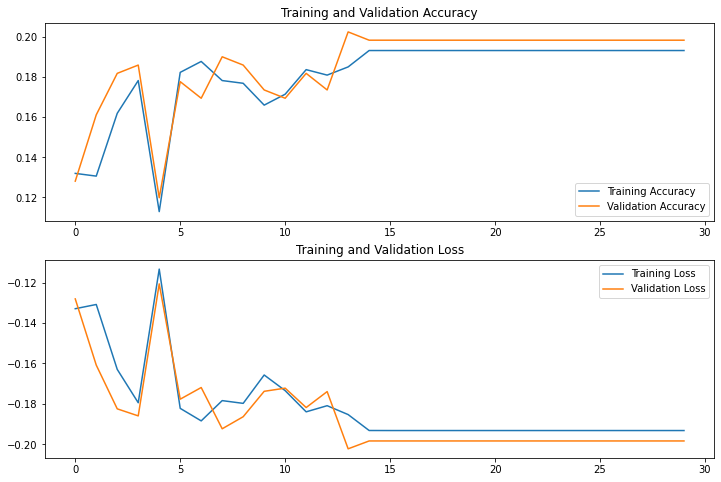

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(len(acc))
plt.figure(figsize=(12, 8))
plt.subplot(2, 1, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')
plt.subplot(2, 1, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [ ]:
from tensorflow.keras.models import load_model
model = load_model('/content/drive/MyDrive/Tesis/imageClassificationWeights/originalData/Inception/inception_retail.h5')

In [ ]:
test_loss,test_acc = model.evaluate(test_ds,verbose=2)
print("Test accuracy:",test_acc)

8/8 - 27s - loss: 1.4140 - accuracy: 0.7812 - 27s/epoch - 3s/step
Test accuracy: 0.78125


In [ ]:
cwd = os.getcwd()
dir = os.path.join(cwd,"images")
preds = []
labels = []
for sub_dir in os.listdir(test_dir):
  for img_name in os.listdir(os.path.join(test_dir,sub_dir)):
    img_dir = os.path.join(test_dir,sub_dir,img_name)
    #print(img_dir)
    img = tf.keras.utils.load_img(img_dir, target_size=(img_height, img_width))
    img = tf.keras.utils.img_to_array(img)
    img = tf.expand_dims(img, 0)
    #img = preprocess_input(img)
    pred = model.predict(img)
    labels.append(int(sub_dir)-2)
    pred = list(pred[0])
    preds.append(int(test_ds.class_names[np.argmax(pred)])-2)
    
    assert 0 <= preds[-1] <= num_classes-1
    

    
    #print(pred)
    #break
  #break

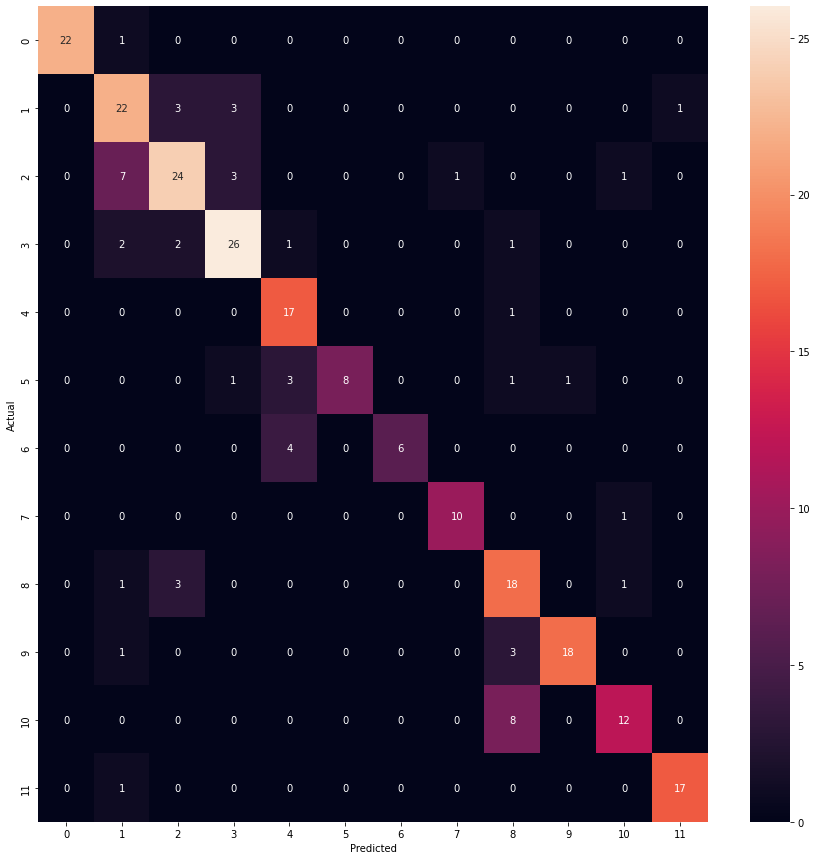

In [ ]:
from sklearn.metrics import confusion_matrix

assert len(labels) == len(preds)
conf_matrix = confusion_matrix(labels,preds)#tf.math.confusion_matrix(labels=labels, predictions=preds, num_classes=num_classes)
#conf_matrix
plt.figure(figsize=(15, 15))
conf_matrix = pd.crosstab(np.array(labels), np.array(preds), rownames=['Actual'], colnames=['Predicted'])
sns.heatmap(conf_matrix, annot=True)

plt.show()

In [ ]:
#https://towardsdatascience.com/confusion-matrix-for-your-multi-class-machine-learning-model-ff9aa3bf7826
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
print('\nAccuracy: {:.5f}\n'.format(accuracy_score(labels, preds)))

print('Micro Precision: {:.5f}'.format(precision_score(labels, preds, average='micro')))
print('Micro Recall: {:.5f}'.format(recall_score(labels, preds, average='micro')))
print('Micro F1-score: {:.5f}\n'.format(f1_score(labels, preds, average='micro')))

print('Macro Precision: {:.5f}'.format(precision_score(labels, preds, average='macro')))
print('Macro Recall: {:.5f}'.format(recall_score(labels, preds, average='macro')))
print('Macro F1-score: {:.5f}\n'.format(f1_score(labels, preds, average='macro')))

print('Weighted Precision: {:.5f}'.format(precision_score(labels, preds, average='weighted')))
print('Weighted Recall: {:.5f}'.format(recall_score(labels, preds, average='weighted')))
print('Weighted F1-score: {:.5f}'.format(f1_score(labels, preds, average='weighted')))


Accuracy: 0.78125

Micro Precision: 0.78125
Micro Recall: 0.78125
Micro F1-score: 0.78125

Macro Precision: 0.83415
Macro Recall: 0.78038
Macro F1-score: 0.79258

Weighted Precision: 0.80649
Weighted Recall: 0.78125
Weighted F1-score: 0.78296


In [ ]:
from sklearn.metrics import classification_report
report = classification_report(labels, preds, target_names=['Class {0}'.format(i+1) for i in range(num_classes)])
print(report)

              precision    recall  f1-score   support

     Class 1       1.00      0.96      0.98        23
     Class 2       0.63      0.76      0.69        29
     Class 3       0.75      0.67      0.71        36
     Class 4       0.79      0.81      0.80        32
     Class 5       0.68      0.94      0.79        18
     Class 6       1.00      0.57      0.73        14
     Class 7       1.00      0.60      0.75        10
     Class 8       0.91      0.91      0.91        11
     Class 9       0.56      0.78      0.65        23
    Class 10       0.95      0.82      0.88        22
    Class 11       0.80      0.60      0.69        20
    Class 12       0.94      0.94      0.94        18

    accuracy                           0.78       256
   macro avg       0.83      0.78      0.79       256
weighted avg       0.81      0.78      0.78       256



# Xception

In [10]:
img_height,img_width = 150,150
batch_size = 32

In [13]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  train_dir,
  label_mode = 'categorical',
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)#porque batch size?


Found 735 files belonging to 12 classes.


In [14]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  val_dir,
  label_mode = 'categorical',
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)#porque batch size?

Found 242 files belonging to 12 classes.


In [15]:
test_ds = tf.keras.preprocessing.image_dataset_from_directory(
  test_dir,
  label_mode = 'categorical',
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)#porque batch size?

Found 256 files belonging to 12 classes.


In [16]:
train_ds.class_names

['10', '11', '12', '13', '2', '3', '4', '5', '6', '7', '8', '9']

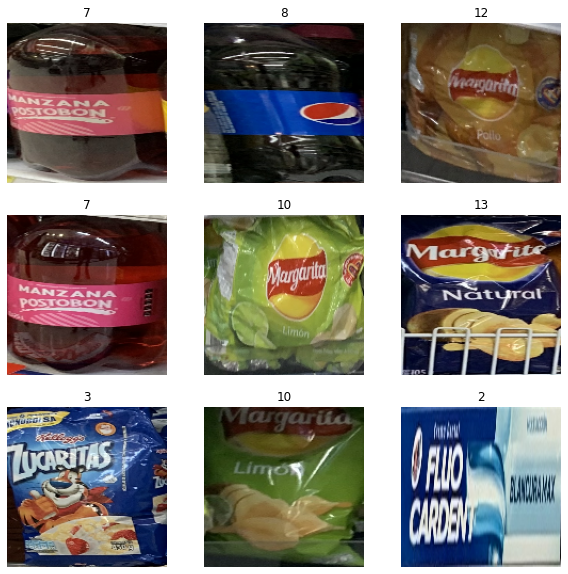

In [ ]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(train_ds.class_names[labels[i]])
    plt.axis("off")


In [17]:
from tensorflow.keras.applications.xception import Xception
xception = Xception(include_top=False,weights='imagenet',input_shape=(img_height,img_width,3))

xception.trainable = False
inputs = tf.keras.Input(shape=(img_height,img_width,3))
x = xception(inputs,training=False)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
outputs = tf.keras.layers.Dense(num_classes,activation='softmax')(x)
model = tf.keras.Model(inputs,outputs)

# x = resnet.output
# x = GlobalAveragePooling2D()(x)
# x = Dense(1024,activation='relu')(x)
# preds = Dense(num_classes,activation='softmax')(x)
# model = Model(inputs=resnet.input,outputs=preds)

#for layer in resnet.layers:
#  layer.trainable = False

model.compile(optimizer='adam',loss=tf.keras.losses.CosineSimilarity(axis=-1),metrics=['accuracy'])
model.summary()


83697664/83683744 [==============================] - 1s 0us/step
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 xception (Functional)       (None, 5, 5, 2048)        20861480  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 12)                24588     
                                                                 
Total params: 20,886,068
Trainable params: 24,588
Non-trainable params: 20,861,480
_________________________________________________________________


In [18]:
%%time
epochs = 30
history = model.fit(train_ds,epochs=epochs,validation_data=val_ds)

Epoch 1/30
23/23 [==============================] - 181s 6s/step - loss: -0.1923 - accuracy: 0.1823 - val_loss: -0.2030 - val_accuracy: 0.1942
Epoch 2/30
23/23 [==============================] - 75s 3s/step - loss: -0.1859 - accuracy: 0.1837 - val_loss: -0.1982 - val_accuracy: 0.1983
Epoch 3/30
23/23 [==============================] - 76s 3s/step - loss: -0.1917 - accuracy: 0.1918 - val_loss: -0.1983 - val_accuracy: 0.1983
Epoch 4/30
23/23 [==============================] - 76s 3s/step - loss: -0.1953 - accuracy: 0.1946 - val_loss: -0.1983 - val_accuracy: 0.1983
Epoch 5/30
23/23 [==============================] - 77s 3s/step - loss: -0.1929 - accuracy: 0.1918 - val_loss: -0.1983 - val_accuracy: 0.1983
Epoch 6/30
23/23 [==============================] - 77s 3s/step - loss: -0.1967 - accuracy: 0.1959 - val_loss: -0.1983 - val_accuracy: 0.1983
Epoch 7/30
23/23 [==============================] - 77s 3s/step - loss: -0.1988 - accuracy: 0.1986 - val_loss: -0.1983 - val_accuracy: 0.1983
Epoch

In [ ]:
model.save('content/xception_retail_cosine.h5')

/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


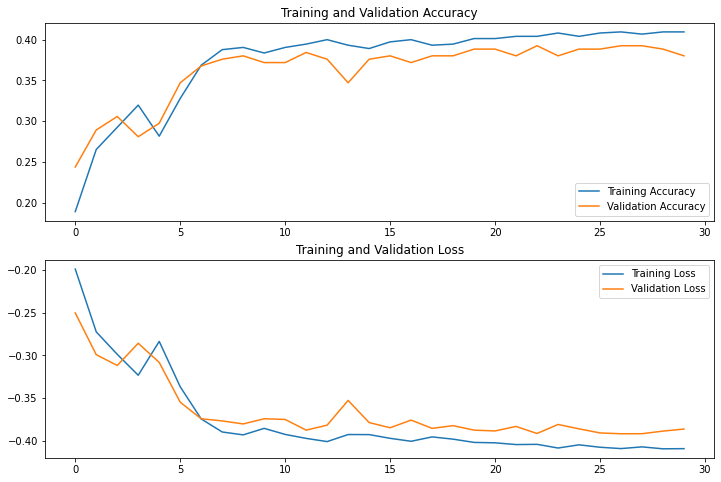

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(len(acc))
plt.figure(figsize=(12, 8))
plt.subplot(2, 1, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')
plt.subplot(2, 1, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [ ]:
from tensorflow.keras.models import load_model
model = load_model('/content/drive/MyDrive/Tesis/imageClassificationWeights/originalData/Xception/xception_retail.h5')

In [ ]:
test_loss,test_acc = model.evaluate(test_ds,verbose=2)
print("Test accuracy:",test_acc)

8/8 - 20s - loss: 0.6291 - accuracy: 0.8281 - 20s/epoch - 2s/step
Test accuracy: 0.828125


In [ ]:
#model = tf.keras.models.load_model("/content/drive/MyDrive/Tesis/imageClassificationWeights/Resnet/resnet_retail.h5")
# preds = list(model.predict(test_ds))
# preds = [list(preds[i]).index(max(preds[i])) for i in range(len(preds))]
# preds
cwd = os.getcwd()
dir = os.path.join(cwd,"images")
preds = []
labels = []
for sub_dir in os.listdir(test_dir):
  for img_name in os.listdir(os.path.join(test_dir,sub_dir)):
    img_dir = os.path.join(test_dir,sub_dir,img_name)
    #print(img_dir)
    img = tf.keras.utils.load_img(img_dir, target_size=(img_height, img_width))
    img = tf.keras.utils.img_to_array(img)
    img = tf.expand_dims(img, 0)
    #img = preprocess_input(img)
    pred = model.predict(img)
    labels.append(int(sub_dir)-2)
    pred = list(pred[0])
    preds.append(int(test_ds.class_names[np.argmax(pred)])-2)
    
    assert 0 <= preds[-1] <= num_classes-1
    

    
    #print(pred)
    #break
  #break

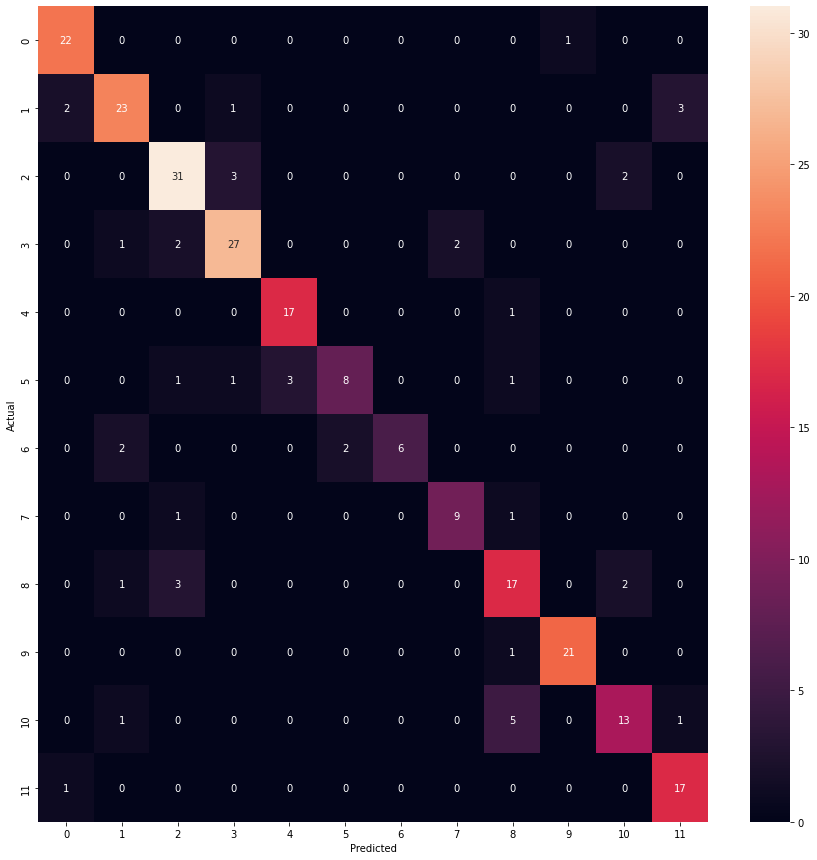

In [ ]:
from sklearn.metrics import confusion_matrix

assert len(labels) == len(preds)
conf_matrix = confusion_matrix(labels,preds)#tf.math.confusion_matrix(labels=labels, predictions=preds, num_classes=num_classes)
#conf_matrix
plt.figure(figsize=(15, 15))
conf_matrix = pd.crosstab(np.array(labels), np.array(preds), rownames=['Actual'], colnames=['Predicted'])
sns.heatmap(conf_matrix, annot=True)

plt.show()

In [ ]:
#https://towardsdatascience.com/confusion-matrix-for-your-multi-class-machine-learning-model-ff9aa3bf7826
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
print('\nAccuracy: {:.5f}\n'.format(accuracy_score(labels, preds)))

print('Micro Precision: {:.5f}'.format(precision_score(labels, preds, average='micro')))
print('Micro Recall: {:.5f}'.format(recall_score(labels, preds, average='micro')))
print('Micro F1-score: {:.5f}\n'.format(f1_score(labels, preds, average='micro')))

print('Macro Precision: {:.5f}'.format(precision_score(labels, preds, average='macro')))
print('Macro Recall: {:.5f}'.format(recall_score(labels, preds, average='macro')))
print('Macro F1-score: {:.5f}\n'.format(f1_score(labels, preds, average='macro')))

print('Weighted Precision: {:.5f}'.format(precision_score(labels, preds, average='weighted')))
print('Weighted Recall: {:.5f}'.format(recall_score(labels, preds, average='weighted')))
print('Weighted F1-score: {:.5f}'.format(f1_score(labels, preds, average='weighted')))


Accuracy: 0.82422

Micro Precision: 0.82422
Micro Recall: 0.82422
Micro F1-score: 0.82422

Macro Precision: 0.83431
Macro Recall: 0.80639
Macro F1-score: 0.81315

Weighted Precision: 0.82748
Weighted Recall: 0.82422
Weighted F1-score: 0.82146


In [ ]:
from sklearn.metrics import classification_report
report = classification_report(labels, preds, target_names=['Class {0}'.format(i+1) for i in range(num_classes)])
print(report)

              precision    recall  f1-score   support

     Class 1       0.88      0.96      0.92        23
     Class 2       0.82      0.79      0.81        29
     Class 3       0.82      0.86      0.84        36
     Class 4       0.84      0.84      0.84        32
     Class 5       0.85      0.94      0.89        18
     Class 6       0.80      0.57      0.67        14
     Class 7       1.00      0.60      0.75        10
     Class 8       0.82      0.82      0.82        11
     Class 9       0.65      0.74      0.69        23
    Class 10       0.95      0.95      0.95        22
    Class 11       0.76      0.65      0.70        20
    Class 12       0.81      0.94      0.87        18

    accuracy                           0.82       256
   macro avg       0.83      0.81      0.81       256
weighted avg       0.83      0.82      0.82       256

